# Clases R

Repositorio con las notas: https://github.com/matiasbattocchia/clases-aprendizaje-automatico

In [ ]:
#install.packages('tidyverse')
library('tidyverse')

#install.packages('ggExtra')
library('gridExtra')
library('ggExtra')
library('ggplot2')

#install.packages('caret')
library('caret')

Esto es para que se vean mejor los gráficos en Jupyter.

In [4]:
library('repr')
options(repr.plot.width=3, repr.plot.height=3)

## Flujo de trabajo

1. Limpieza de los datos
2. Preprocesamiento
3. Modelado

Usamos el paquete [`caret`](https://topepo.github.io/caret/data-splitting.html) que implementa funciones utilitarias varias.

Estos podría ser una buena alternativa a `caret`, inspirada en la librería `scikit-learn` de Python:

https://alexioannides.com/2017/05/08/machine-learning-pipelines-for-r

In [3]:
#devtools::install_github("alexioannides/pipeliner")

## Limpieza de los datos

Saltamos este paso por el momento. Utilizaremos los conjuntos de datos de ejemplo provistos por R.

El conjunto de datos de `iris` tiene cuatro variables independientes y una dependiente que es categórica (es un conjunto para **clasificación**).

In [4]:
head(iris)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


## Preprocesamiento

Una vez que los datos están en condiciones suelen atravesar diversas transformaciones que mejoran la calidad del modelo. Veremos dos técnicas bastante útiles:

1. Estandarización
2. Análisis de componentes principales

Previo a transformar el conjunto de datos es necesario separarlo en conjuntos de **desarrollo** y **prueba**. Si bien todos los datos son eventualmente transformados, las transformaciones se determinan en base al conjunto de desarollo; "se entrenan" de manera a similar a como se entrenan los modelos, de la misma manera debemos evitar mostrar los datos de prueba durante el preprocesamiento.

Particionamos los datos en los conjuntos y proporciones
* `train` 80% y
* `test` 20%.

In [5]:
set.seed(3456)

train_index <- createDataPartition(iris$Species, p=0.8, list=FALSE)

train <- iris[ train_index,]
test  <- iris[-train_index,]

### Estandarización

Consiste en alguna o ambas de estas operaciones:

1. Centrado
2. Escaleado

Para entender mejor de qué se trata este proceso es conveniente graficar el conjunto de datos. En particular el que estamos usando tiene cuatro variables independientes pero vamos a graficar dos (se requiere una dimensión espacial por variable, es difícil graficar más de tres variables simultáneamente).

La estandarización afecta a todas las variables a excepción de las dependientes, que quedan dejadas de lado; es como si estuviésemos realizando **aprendizaje no supervisado**. Por comodidad vamos a ejemplificar solo dos de las variables.

In [116]:
a <- ggplot(train, aes(Petal.Length, Petal.Width)) +
        geom_point(alpha=0.3) + 
        scale_x_continuous(limits=c(-7,7)) + 
        scale_y_continuous(limits=c(-7,7)) +
        theme_bw() +
        labs(title='Original', x='Largo', y='Ancho')

#### Centrado

Consiste en disponer los datos alrededor del *origen de coordenadas*, el punto `(0,0)` que es donde empezamos a contar las distancias en sendas dimensiones.

Primero debemos encontrar el "centro" de los datos, que está dado por `(promedio X1, promedio X2)`. Luego restamos el centro a los datos para obtener un nuevo `data frame` transformado.

In [ ]:
promedio_petal_length = mean(train$Petal.Length)
promedio_petal_width  = mean(train$Petal.Width)

petal_length = train$Petal.Length - promedio_petal_length
petal_width  = train$Petal.Width  - promedio_petal_width

train_centrado = data.frame(petal_length, petal_width)

In [117]:
b <- ggplot(train_centrado, aes(petal_length, petal_width)) +
        geom_point(alpha=0.3) + 
        scale_x_continuous(limits=c(-7,7)) + 
        scale_y_continuous(limits=c(-7,7)) +
        theme_bw() +
        labs(title='Centrado', x='Largo', y='Ancho')

*Notar que los datos ahora gravitan alrededor del punto* `(0,0)`.

#### Escaleado

Hablamos de "escalear" cuando nos referimos a cambiar la escala de una variable, por ejemplo para pasar de metros a kilómetros. 

Con esta transformación se pretende lograr que todas las dimensiones o variables tengan la misma escala. Esto se consigue diviendo todos los valores de una varible por su desviación estándar.

In [ ]:
desviación_petal_length = sd(train$Petal.Length)
desviación_petal_width  = sd(train$Petal.Width)

petal_length = train_centrado$petal_length / desviación_petal_length
petal_width  = train_centrado$petal_width  / desviación_petal_width

train_centrado_escaleado = data.frame(petal_length, petal_width)

In [118]:
c <- ggplot(train_centrado_escaleado, aes(petal_length, petal_width)) +
        geom_point(alpha=0.3) + 
        scale_x_continuous(limits=c(-7,7)) + 
        scale_y_continuous(limits=c(-7,7)) +
        theme_bw() +
        labs(title='Escaleado', x='Largo', y='Ancho')

*Notar que ahora ambas variables tienen la misma escala, van de -1,5 a 1,5.*

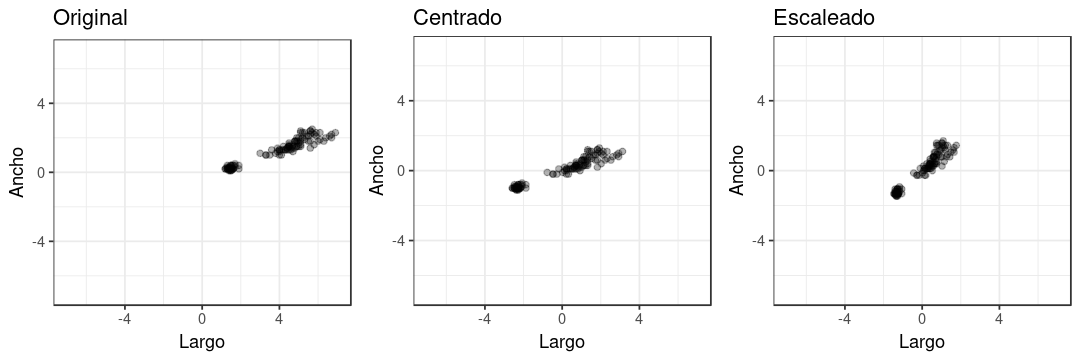

In [119]:
options(repr.plot.width=9, repr.plot.height=3)
grid.arrange(a, b, c, ncol=3)

#### Consideraciones

Si le calculamos el **promedio** y la **varianza** a cualquier varible independiente del conjunto de datos transformado, encontraremos que

In [25]:
round(mean(train_centrado_escaleado$petal_length))

[1] 0

In [19]:
round(var(train_centrado_escaleado$petal_length))

[1] 1

Por eso se dice que en la estandarización **centrar** es llevar el promedio a cero y **escalear**, la varianza a uno. Estos pasos son opcionales: es decir, se puede hacer uno sin el otro y además se los puede realizar en cualquier orden.

Por lo general es conveniente **centrar**, muchos algoritmos están pensados suponiendo que los datos están centrados, como es el caso de
  * SVM (máquina de vectores de soporte) y
  * PCA (análisis de componentes principales).
  
**Escalear** es necesario cuando estamos trabajando con variables que difieren mucho entre sí, por ejemplo *metros cuadrados* (números pequeños) y *precio de una propiedad* (números grandes). Como los algoritmos por lo general son incapaces de advertir la naturaleza de las variables, le terminan dando importancia a las variables con grandes números, que terminan dominando al conjunto de datos y desperdiciando la información contenida en las otras variables. Luego del escaleo todas las variables se parecerán.

Si todas las variables ya se parecen (como sucede con los datos de `iris`) entonces no es necesario. Al escalear perdemos la información de que algunas variables tienen más varianza que otras. Hay algoritmos como *árboles de decisión* que son invariantes de escala (no les importa).

#### Usando `caret`

Lo que acabamos de hacer, en menos líneas.

In [29]:
estandarizador      <- preProcess(train[, 1:4], method=c('center', 'scale'))
train_estandarizado <- predict(estandarizador, train[, 1:4])

### Análsis de componentes principales

Bibliografía:
* http://cs229.stanford.edu/notes/cs229-notes10.pdf
* http://ufldl.stanford.edu/wiki/index.php/PCA

También conocido como PCA por sus siglas en inglés (*principal component analisys*).

PCA es un método de **reducción de dimensionalidad**; sirve para trabajar con menos variables de las que originalmente contamos. (Variable, atributo, dimensión son sinónimos.) ¿Menos es más? A veces sí.

1. Algunos algoritmos aprenden más rápidamente con menos atributos, el tiempo de procesamiento y el espacio de almacenamiento se reducen. Imaginemos pasar de 100 variables a 5.
2. Otra razón por la cuál descartar atributos es para evitar los temidos efectos de [sobreajuste](https://en.wikipedia.org/wiki/Overfitting) y [maldición de la dimensionalidad](https://en.wikipedia.org/wiki/Curse_of_dimensionality).
3. También sirve para graficar en 2D o en 3D datos de mayor dimensionalidad.

TODO: gráfico

La reducción de dimensionalidad se logra en esencia a través de la [**selección de atributos**](https://en.wikipedia.org/wiki/Feature_selection), que es básicamente utilizar un criterio para seleccionar un subconjunto de atributos, no cualquier selección sino la más conveniente para nuestro modelo. La premisa es que los datos suelen contener atributos que son *irrelevantes* o *redundantes* y que pueden ser removidos sin incurrir en demasiada pérdida de información. Si dos atributos están fuertemente correlacionados entonces son redundantes. 

Existen diversas maneras de remover atributos ([algunas técnicas](http://scikit-learn.org/stable/modules/feature_selection.html)).

1. Conforme a su varianza,
2. según tests estadísticos,
3. según la información proporcionada por otros modelos,
4. eliminación recursiva.

Nos vamos a centrar en la primera de las opciones ya que es la utilizada por PCA—*descarta los atributos de menor varianza*. En general se considera que las dimensiones que varían poco no contribuyen a explicar los datos, son irrelevantes.

PCA es el producto de realizar una [**extracción de atributos**](https://en.wikipedia.org/wiki/Feature_extraction) seguida por una selección de atributos. La extracción de atributos es la generación de nuevos atributos a partir de los existentes por medio de una transformación. Este proceso no crea ni destruye información, solo cambia "el punto de vista" que se tiene de los datos en pos de conseguir atributos informativos y no redundantes.

En particular PCA realiza una transformación lineal de los datos, más específicamente, una rotación. Para lograr una rotación se definen nuevos ejes a partir de los originales (es lo que en álgebra lineal se conoce como *cambio de base*). Los nuevos ejes o atributos reciben el nombre de componentes principales. La primera componente principal es la dimensión que exhibe la mayor varianza. Las subsiguientes componentes principales se contruyen en base a las anteriores: la segunda, que es la segunda en varianza, forma un ángulo recto respecto de la primera, la tercera forma ángulos rectos respecto a la primera y a la segunda, así sucesivamente.

Luego de la rotación, se selecciona cierta cantidad de componentes principales, que son las de mayor varianza y se descarta el resto. PCA cumple su cometido cuando podemos explicar la mayor parte de la variabilidad de los datos con utilizando menos atributos.  

Warning message:
“Removed 10 rows containing missing values (geom_bar).”

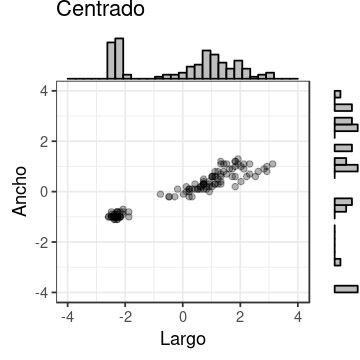

In [130]:
options(repr.plot.width=3, repr.plot.height=3)

d <- ggplot(train_centrado, aes(petal_length, petal_width)) +
        geom_point(alpha=0.3) + 
        scale_x_continuous(limits=c(-4,4)) + 
        scale_y_continuous(limits=c(-4,4)) +
        theme_bw() +
        labs(title='Centrado', x='Largo', y='Ancho')

ggMarginal(d, type='histogram')

In [36]:
pca <- prcomp(train_centrado, center=FALSE, scale.=FALSE)
pca

Standard deviations (1, .., p=2):
[1] 1.915102113993 0.194634252948

Rotation (n x k) = (2 x 2):
                        PC1             PC2
petal_length 0.922856873747 -0.385143078060
petal_width  0.385143078060  0.922856873747

In [37]:
PC1 =  0.923 * train_centrado$petal_length + 0.385 * train_centrado$petal_width
PC2 = -0.385 * train_centrado$petal_length + 0.923 * train_centrado$petal_width

train_rotado = data.frame(PC1, PC2)

Los nuevos atributos, `PC1` y `PC2`, al ser una combinación de atributos reales, puede que carezcan de significado.

Warning message:
“Removed 12 rows containing missing values (geom_bar).”

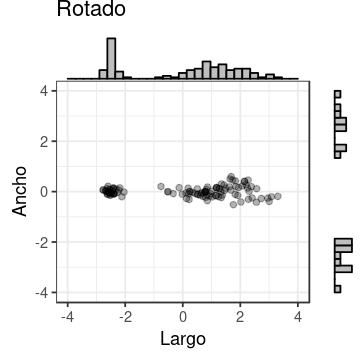

In [131]:
e <- ggplot(train_rotado, aes(PC1, PC2)) +
        geom_point(alpha=0.3) + 
        scale_x_continuous(limits=c(-4,4)) + 
        scale_y_continuous(limits=c(-4,4)) +
        theme_bw() +
        labs(title='Rotado', x='Largo', y='Ancho')

ggMarginal(e, type='histogram')

Comparemos las varianzas de los datos antes y después de PCA.

In [134]:
var(train_centrado)

,petal_length,petal_width
petal_length,3.12919887955,1.290123249300
petal_width,1.29012324930,0.576299719888


In [135]:
var(train_rotado)

,PC1,PC2
PC1,3.668180792747900,0.000679410142857
PC2,0.000679410142857,0.037888453476190


Hemos pasado de dos atributos (`petal_length` y `petal_width`) con varianzas semejantes a dos atributos de los cuales uno (`PC1`) presenta mayor varianza respecto al otro (`PC2`).

![](https://media.giphy.com/media/Lyejb62QjQepG/source.gif)

---

Anteriormente usamos solo dos atributos del conjunto de datos de flores de iris, a modo de ejemplo y para simplificar. Veamos que pasa al usar los cuatros atributos.

In [153]:
estandarizador <- preProcess(train[, 1:4], method=c('center'))
train_centrado <- predict(estandarizador, train[, 1:4])

pca       <- prcomp(train_centrado, center=FALSE, scale.=FALSE)
train_pca <- as.data.frame(predict(pca, train_centrado))

In [149]:
summary(pca)

Importance of components:
                              PC1         PC2         PC3         PC4
Standard deviation     2.06072276 0.499990675 0.277605695 0.161907881
Proportion of Variance 0.92320000 0.054350000 0.016750000 0.005700000
Cumulative Proportion  0.92320000 0.977550000 0.994300000 1.000000000

Se obtienen cuatro componentes principales. Como los atributos originales están algo correlacionados y presentan redundancia (por ejemplo los pétalos que son largos también son anchos y viceversa), conservando las primeras dos o tres componentes principales ya explicamos prácticamente toda la varianza de los datos.

Esto mismo puede ser representado gráficamente:

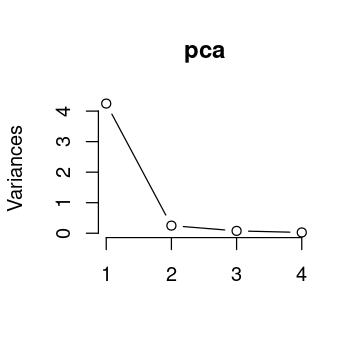

In [150]:
plot(pca, type='l')

¿Cuántas componentes principales conservar? Esto se puede decidir de varias maneras.

1. Entrenando y evaluando modelos, variando la cantidad de componentes principales, dejando que las métricas hablen.
2. Estableciendo una cota de antemano, por ejemplo el 95% de la varianza acumulada. Del reporte anterior vemos que PC1 y PC2 son suficientes ya que acumulan el 98% de la varianza de los datos.
3. Observando un gráfico como el anterior, haciendo un corte cuando las componentes dejan de aportar varianza significativamente.

#### Con caret

La función `preProcess` nos posibilita estandarizar y aplicar PCA de manera sucinta, además de especificar un umbral (`thresh`) de varianza.

In [154]:
transformaciones <- preProcess(train[, 1:4], method=c('center', 'pca'), thresh=0.6)

train_transformado <- predict(transformaciones, train[, 1:4])
test_transformado  <- predict(transformaciones, test[, 1:4])

*Notar que las transformaciones se crean a partir de los datos de entrenemiento exclusivamente*. Luego se utilizan para transformar tanto los datos de entrenamiento como los de prueba.

## Modelado

### SVM

Las **máquinas de vectores de soporte** son modelos de **aprendizaje supervisado** para clasificación y regresión.

Dado un conjunto de entrenamiento, cada muestra con pertenencia a una u otra categoría de dos posibles, el algoritmo de SVM construye un modelo que asigna a nuevas muestras una categoría o la otra.

Es una representación de las muestras de entrenamiento como puntos en un espacio, con un mapeo tal que las muestras de categorías distintas están divididas por una brecha vacía lo más ancha posible. Los nuevas muestras son mapeadas en ese mismo espacio y se les predice una categoría según a cual lado de la brecha caen.  

Es un modelo no probabilístico, binario y lineal. También puede realizar clasificación no lineal a través del **truco del núcleo** (*kernel trick*), que mapea a las muestras en un espacio con más dimensiones que las originales. Cuando las muestras no están anotadas, SVM no sirve.

---

Vamos a trabajar con el dataset `iris`. Tiene cuatro variables independientes—para simplificar la explicación vamos a trabajar solo con dos. El dataset además tiene una variable categórica que separa a las muestras en tres categorías—también para simplificar vamos a elegir solo dos. En principio porque SVM es un clasificador binario, aunque más adelante veremos que no está limitado a solo dos categorías.

In [72]:
simple = train[train$Species %in% c('setosa','virginica'), c('Petal.Length','Petal.Width','Species')]

Elegimos dos muestras de cada clase para ejemplificar qué queremos decir con ubicarlas en un espacio.

In [81]:
ejemplos = simple[c(1,5,51,52),]

ejemplos

,Petal.Length,Petal.Width,Species
1,1.4,0.2,setosa
6,1.7,0.4,setosa
116,5.3,2.3,virginica
117,5.5,1.8,virginica


Cada variable es mapeada a una dimensión del espacio. Si tenemos dos variables vamos a necesitar un espacio de dos dimensiones, un plano. Justamente para que sea posible visualizar este espacio fue que nos restringimos a dos variables, sin embargo SVM no tiene limitaciones respecto a las dimensiones; las matemáticas siguen funcionando.

Identificamos la clase de cada muestra utilizando un color o un marcador diferente.

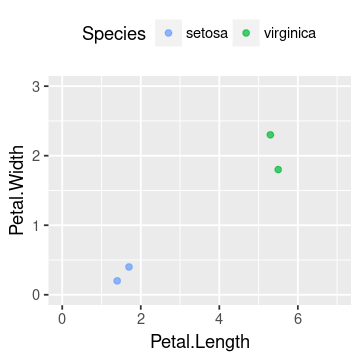

In [108]:
dispersión = ggplot(ejemplos, aes(x=Petal.Length, y=Petal.Width, color=Species)) + 
        geom_point(alpha=0.7) +
        scale_x_continuous(limits=c(0,7)) + 
        scale_y_continuous(limits=c(0,3)) + 
        theme(legend.position='top') +
        scale_color_manual(values=c('#619cff','#00ba38'))

#ggsave(file='ejemplos.svg', plot=dispersión, width=3, height=3)
dispersión

Ahora procedemos a graficar todas las muestras.

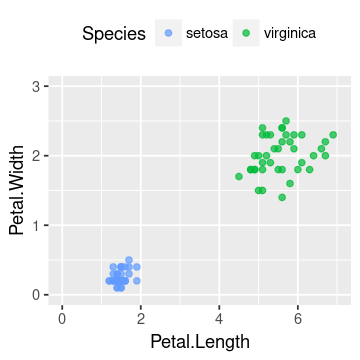

In [104]:
dispersión = ggplot(simple, aes(x=Petal.Length, y=Petal.Width, color=Species)) + 
        geom_point(alpha=0.7) +
        scale_x_continuous(limits=c(0,7)) + 
        scale_y_continuous(limits=c(0,3)) + 
        theme(legend.position='top') + 
        scale_color_manual(values=c('#619cff','#00ba38'))

#ggsave(file='separable.svg', plot=dispersión, width=3, height=3)
dispersión

In [85]:
no_separable = train[train$Species %in% c('versicolor','virginica'), c('Petal.Length','Petal.Width','Species')]

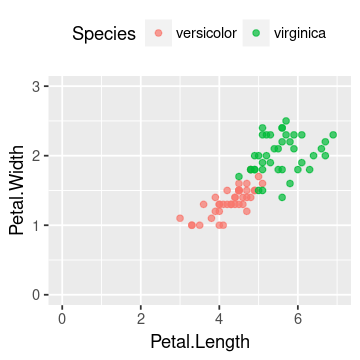

In [106]:
dispersión = ggplot(no_separable, aes(x=Petal.Length, y=Petal.Width, color=Species)) + 
        geom_point(alpha=0.7) +
        scale_x_continuous(limits=c(0,7)) + 
        scale_y_continuous(limits=c(0,3)) + 
        theme(legend.position='top') +
        scale_color_manual(values=c('#f8766d','#00ba38'))

#ggsave(file='no_separable.svg', plot=dispersión, width=3, height=3)
dispersión

In [88]:
#install.packages('e1071')

library(e1071)

In [89]:
modelo <- svm(Species ~ ., data=train, kernel='linear', cost=1, scale=FALSE)

In [90]:
summary(modelo)


Call:
svm(formula = Species ~ ., data = train, kernel = "linear", cost = 1, 
    scale = FALSE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 
      gamma:  0.25 

Number of Support Vectors:  26

 ( 3 12 11 )


Number of Classes:  3 

Levels: 
 setosa versicolor virginica




---

Ahora utilizamos los datos de prueba para determinar la calidad del modelo.

In [94]:
x <- subset(test, select=-Species)
y <- test$Species

pred <- predict(modelo, x)

table(pred, y)

            y
pred         setosa versicolor virginica
  setosa         10          0         0
  versicolor      0         10         0
  virginica       0          0        10

---

Este es un resumen un poco más interesante que la matriz de confusión ya que además reporta algunas métricas.

In [95]:
confusionMatrix(pred, y)

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         10          0         0
  versicolor      0         10         0
  virginica       0          0        10

Overall Statistics
                                          
               Accuracy : 1               
                 95% CI : (0.884296692, 1)
    No Information Rate : 0.333333333     
    P-Value [Acc > NIR] : 4.85693575e-15  
                                          
                  Kappa : 1               
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity            1.000000000       1.000000000      1.000000000
Specificity            1.000000000       1.000000000      1.000000000
Pos Pred Value         1.000000000       1.000000000      1.000000000
Neg Pred Value         1.000000000       1.000000000      1.000000000
Prevalence             0.333333333       0.3

---

La mejor forma de determinar el valor del parámetro `costo` es mediante los datos de validación.

In [106]:
ajuste <- tune.svm(Species ~ ., data=train, kernel='linear', cost=c(0.001, 0.01, 0.1, 1, 5, 10, 100) )

#summary(ajuste)
summary(ajuste$best.model)


Call:
best.svm(x = Species ~ ., data = train, cost = c(0.001, 0.01, 0.1, 
    1, 5, 10, 100), kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  1 
      gamma:  0.25 

Number of Support Vectors:  27

 ( 2 14 11 )


Number of Classes:  3 

Levels: 
 setosa versicolor virginica




## Recursos

http://www.r-bloggers.com


### Textos

[An Introduction to R](https://cran.r-project.org/doc/manuals/R-intro.pdf) — W. N. Venables, D. M. Smith, R Core Team.

Más de programación, tiene modelos lineales.

---

[R for Data Science](http://r4ds.had.co.nz) — Garrett Grolemund, Hadley Wickham.

Lo recomiendan en RStudio.

---

[Introduction to Probability and Statistics Using R](https://cran.r-project.org/web/packages/IPSUR/vignettes/IPSUR.pdf) — G. Jay Kerns.

Mas o menos útil. Es parte de la documentación oficial.

---

[Advanced R](http://adv-r.had.co.nz) — Hadley Wickham.

Me sirvió la parte de estructuras de datos.

---

[Vectores atómicos](http://arrgh.tim-smith.us/atomic.html)

Lectura obligada.

---

[An Introduction to Statistical Learning with Applications in R](http://www-bcf.usc.edu/~gareth/ISL) — Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani.

Es el que usé para aprendizaje automático. Está el **Elements of Statistical Learning** que es más avanzado.

---

[Advanced Data Analysis from an Elementary Point of View](http://www.stat.cmu.edu/~cshalizi/ADAfaEPoV) — Cosma Rohilla Shalizi.

Cubre muchos tópicos avanzados, siendo exigente, desde un punto de vista elemental.

---

Más textos:
  * https://r-dir.com/learn/e-books.html
  * https://www.ossblog.org/grasp-r-programming-open-source-books
  * http://freecomputerbooks.com/langRBooks.html